What I implemented:
- Load the dataset and inpect for shapes, columns, missing values, etc.
- Identify the pIC50 endpoints
- Use OECHEM to parse CXSMILES into OpenEye molecular objects
- Generate 3D conformers (OEOMEGA)
- Create numerical features
- EDA on the features

My findings:
I used OEChem to convert the textual molecular representation into a chemical object. Most molecules (1328/1328) were successfully parsed. Then I used OEOmega to generate one 3D conformer per molecule. This step transforms the 2D molecular structure into a 3D geometry. A small number of molecules failed 3D generation (7/1328), which is expected for complex or ambiguous structures. Finally, I extracted 5 basic OpenEye-based numerical features from each molecule, including: 3D conformer success indicator , Number of atoms , Number of bonds , Molecular weight , Number of rotatable bonds is this correct

- 99.47% molecules successfully tranformed. Average molecule contains 49.6 atoms and 52.8 bonds (4.9 rotatable bonds) with 383.6 weight
- Most of molecules have 40-80 atoms
- Most of molecules have 40-75 bonds
- The number of bonds closely follows the atom distribution, as bonds increase with molecular size.
- There is strong positive relationship between number of atoms and molecule weight.

In [1]:
%pip install matplotlib seaborn polaris lightgbm scikit-learn

  Using cached sqlalchemy-2.0.47-cp310-cp310-win_amd64.whl.metadata (9.8 kB)
Using cached sqlalchemy-2.0.47-cp310-cp310-win_amd64.whl (2.1 MB)
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.54
    Uninstalling SQLAlchemy-1.4.54:
      Successfully uninstalled SQLAlchemy-1.4.54
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install "sqlalchemy>=1.4,<2.0" "flask-sqlalchemy<3.0" --force-reinstal

  Using cached SQLAlchemy-1.4.54-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached greenlet-3.3.2-cp310-cp310-win_amd64.whl.metadata (3.8 kB)
  Using cached flask-3.1.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached markupsafe-3.0.3-cp310-cp310-win_amd64.whl.metadata (2.8 kB)
  Using cached werkzeug-3.1.6-py3-none-any.whl.metadata (4.0 kB)
Using cached SQLAlchemy-1.4.54-cp310-cp310-win_amd64.whl (1.6 MB)
Using cached flask-3.1.3-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)
Using cached greenlet-3.3.2-cp310-cp310-win_amd64.whl (230 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 

In [3]:
from openeye import oechem,oequacpac,oeomega,oeshape
import polaris as po 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, plot_importance 
from sklearn.metrics import r2_score, mean_squared_error 
import seaborn as sns 
from sys import exit
from IPython import display

In [8]:
# Load the dataset
CSV = "antiviral_potency_2025_unblinded.csv"
df = pd.read_csv(CSV)

# Display basic information about the dataset
print("Dataset shape (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns)
df.head()

# Identify columns that contain pIC50 values
pIC50_cols = [c for c in df.columns if "pIC50" in c]

print(pIC50_cols)

# Check for missing values in the dataset
missing_counts = df.isna().sum().sort_values(ascending=False)

print(missing_counts)

Dataset shape (rows, columns): (1328, 5)

Column names:
Index(['CXSMILES', 'Molecule Name', 'Set', 'pIC50 (MERS-CoV Mpro)',
       'pIC50 (SARS-CoV-2 Mpro)'],
      dtype='object')
['pIC50 (MERS-CoV Mpro)', 'pIC50 (SARS-CoV-2 Mpro)']
pIC50 (SARS-CoV-2 Mpro)    223
pIC50 (MERS-CoV Mpro)      130
CXSMILES                     0
Set                          0
Molecule Name                0
dtype: int64


The dataset contains 1328 molecules with 5 columns

pIC50 for MERS-CoV and SARS-CoV-2 are endpoints

Missing Value: pIC50 (SARS-CoV-2 Mpro)  223 pIC50 (MERS-CoV Mpro)    130




In [ ]:
from openeye import oechem

# ---- IMPORTANT: set this to your SMILES column name ----
smiles_col = "CXSMILES"   # change if your column is named differently

def smiles_to_oemol(smiles: str):
    if not isinstance(smiles, str) or not smiles.strip():
        return None
    mol = oechem.OEMol()
    if not oechem.OESmilesToMol(mol, smiles):
        return None
    oechem.OEAssignAromaticFlags(mol)
    oechem.OEAddExplicitHydrogens(mol)
    return mol

mols = []
parse_ok = 0
for s in df[smiles_col].astype(str):
    m = smiles_to_oemol(s)
    mols.append(m)
    parse_ok += int(m is not None)

print("Parsed molecules:", parse_ok, "/", len(mols))

# Display information about the first few molecules
for i, m in enumerate(mols[:5]):
    print("Index:", i)
    print("Original SMILES:", df[smiles_col].iloc[i])
    
    if m is not None:
        print("Status: Success")
        print("NumAtoms:", m.NumAtoms())
        print("NumBonds:", m.NumBonds())
    else:
        print("Status: Failed")
    
    print("-" * 40)

Parsed molecules: 1328 / 1328
Index: 0
Original SMILES: COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C |&1:3|
Status: Success
NumAtoms: 39
NumBonds: 41
----------------------------------------
Index: 1
Original SMILES: C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC=CC=C12)C(N)=O
Status: Success
NumAtoms: 51
NumBonds: 54
----------------------------------------
Index: 2
Original SMILES: CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C2=O)C2=C(C=CC(Cl)=C2)C1=O
Status: Success
NumAtoms: 57
NumBonds: 61
----------------------------------------
Index: 3
Original SMILES: C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC=CC=C12)C(=O)OC
Status: Success
NumAtoms: 53
NumBonds: 56
----------------------------------------
Index: 4
Original SMILES: C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC=CC=C12)C(=O)O
Status: Success
NumAtoms: 50
NumBonds: 53
----------------------------------------


In [12]:
from openeye import oeomega

omega = oeomega.OEOmega()
omega.SetMaxConfs(1)          # keep it fast
omega.SetStrictStereo(False)  # fewer failures
omega.SetIncludeInput(False)

conf_ok = []
for m in mols:
    if m is None:
        conf_ok.append(False)
        continue
    try:
        conf_ok.append(bool(omega(m)))
    except Exception:
        conf_ok.append(False)

print("3D conformers succeeded:", sum(conf_ok), "/", len(conf_ok))

3D conformers succeeded: 1321 / 1328


In [13]:
def calc_openeye_features(mol, ok3d: bool):
    """Simple, stable OpenEye-based features suitable for ML."""
    if mol is None:
        return {
            "conf3d_ok": 0,
            "num_atoms": np.nan,
            "num_bonds": np.nan,
            "mol_wt": np.nan,
            "rot_bonds": np.nan
        }
    feats = {"conf3d_ok": int(ok3d)}
    feats["num_atoms"] = mol.NumAtoms()
    feats["num_bonds"] = mol.NumBonds()
    try:
        feats["mol_wt"] = oechem.OECalculateMolecularWeight(mol)
    except Exception:
        feats["mol_wt"] = np.nan
    try:
        feats["rot_bonds"] = oechem.OECount(mol, oechem.OEIsRotor())
    except Exception:
        feats["rot_bonds"] = np.nan
    return feats

feat_df = pd.DataFrame([calc_openeye_features(m, ok) for m, ok in zip(mols, conf_ok)])
print("Feature table shape:", feat_df.shape)
feat_df.head()

Feature table shape: (1328, 5)


,conf3d_ok,num_atoms,num_bonds,mol_wt,rot_bonds
0,1,39,41,299.32448,3
1,1,51,54,420.89144,6
2,1,57,61,452.93330,5
3,1,53,56,435.90278,7
4,1,50,53,421.87620,6


I used OEChem to convert the textual molecular representation into a chemical object. Most molecules (1328/1328) were successfully parsed. Then I used OEOmega to generate one 3D conformer per molecule. This step transforms the 2D molecular structure into a 3D geometry. A small number of molecules failed 3D generation (7/1328), which is expected for complex or ambiguous structures. Finally, I extracted 5 basic OpenEye-based numerical features from each molecule, including: 
3D conformer success indicator 
Number of atoms 
Number of bonds 
Molecular weight 
Number of rotatable bonds is this correct

In [14]:
feat_df.describe()

,conf3d_ok,num_atoms,num_bonds,mol_wt,rot_bonds
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,0.994729,49.565512,52.772590,383.609137,4.869729
std,0.072438,11.232700,12.021875,99.663332,2.439079
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,43.000000,45.000000,317.384360,3.000000
50%,1.000000,47.000000,50.000000,348.461300,4.000000
75%,1.000000,56.000000,60.000000,455.596557,6.000000
max,1.000000,138.000000,143.000000,973.118020,29.000000


99.47% molecules successfully tranformed. Average molecule contains 49.6 atoms and 52.8 bonds (4.9 rotatable bonds) with 383.6 weight

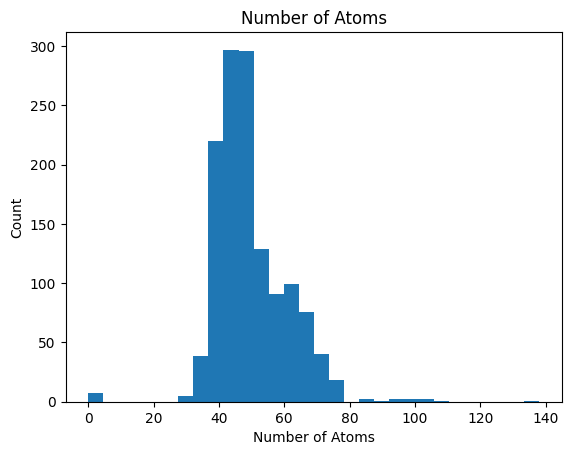

In [23]:
plt.hist(feat_df["num_atoms"].dropna(), bins=30)
plt.title("Number of Atoms")
plt.xlabel("Number of Atoms")
plt.ylabel("Count")
plt.show()

Most of molecules have 40-80 atoms

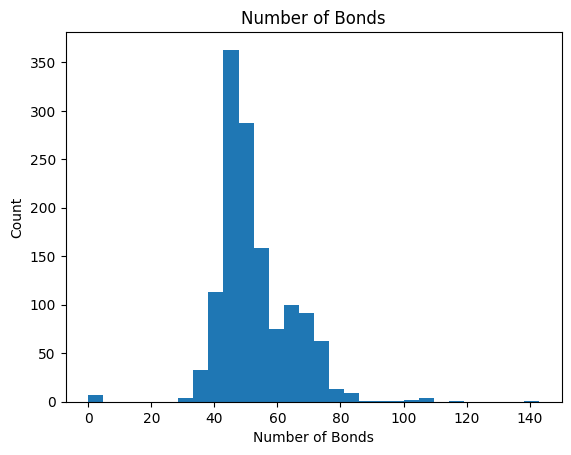

In [21]:
plt.hist(feat_df["num_bonds"].dropna(), bins=30)
plt.title("Number of Bonds")
plt.xlabel("Number of Bonds")
plt.ylabel("Count")
plt.show()

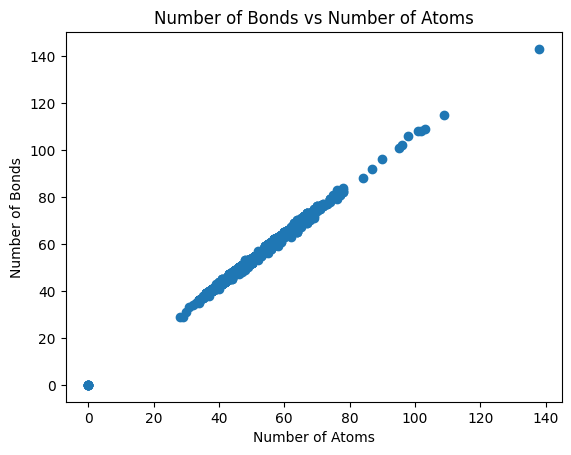

In [24]:
plt.scatter(feat_df["num_atoms"], feat_df["num_bonds"])
plt.title("Number of Bonds vs Number of Atoms")
plt.xlabel("Number of Atoms")
plt.ylabel("Number of Bonds")
plt.show()

Most of molecules have 40-75 bonds

The number of bonds closely follows the atom distribution, as bonds increase with molecular size.

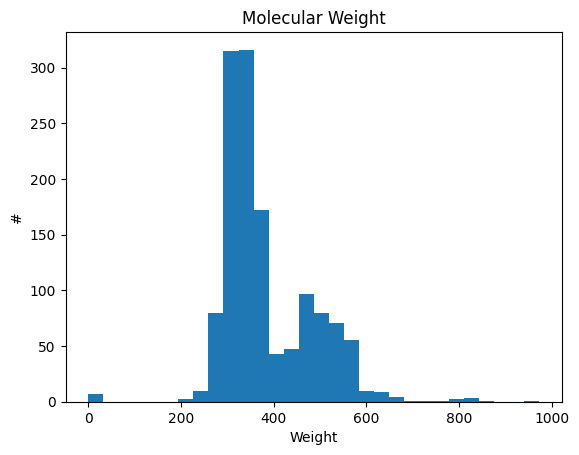

In [18]:
import matplotlib.pyplot as plt

plt.hist(feat_df["mol_wt"].dropna(), bins=30)
plt.title("Molecular Weight")
plt.xlabel("Weight")
plt.ylabel("#")
plt.show()

Weihgt is right skewed (some molecules have very high weights)

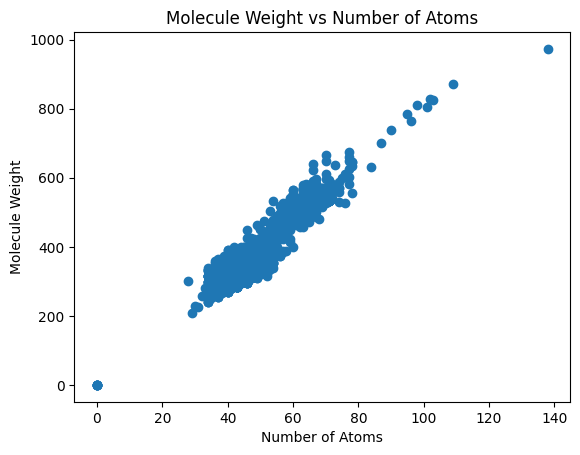

In [19]:
plt.scatter(feat_df["num_atoms"], feat_df["mol_wt"])
plt.title("Molecule Weight vs Number of Atoms")
plt.xlabel("Number of Atoms")
plt.ylabel("Molecule Weight")
plt.show()

There is strong positive relationship between number of atoms and molecule weight